In [1]:
# Import useful libraries
from PIL import Image, ImageChops, ImageEnhance
from torchvision import transforms
import os
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm, trange
import torch
import time
import torchvision.models as models

In [2]:
!featurize dataset download f0d1919b-9429-4c18-a660-7291e30bfbeb

100%|██████████████████████████████████████| 2.56G/2.56G [00:06<00:00, 415MiB/s]
🍬  下载完成，正在解压...
🏁  数据集已经成功添加


In [3]:
from torchvision import transforms
import os.path as path
import random

In [6]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file.jpg'
    ela_filename = 'temp_ela_file.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

def prepare_image(image_path, image_size):
    convert_tensor = transforms.ToTensor()
    return convert_tensor(convert_to_ela_image(image_path, 85).resize(image_size))

In [7]:
X = [] 
Y = []

In [9]:
image_size = (224, 224)

path = 'data/CopyAndMove/Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        X.append(prepare_image(full_path, image_size))
        Y.append(1)  

print(len(X), len(Y))

5000 5000


In [10]:
path = 'data/CopyAndMove/Tp'

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        X.append(prepare_image(full_path, image_size))
        Y.append(0)

print(len(X), len(Y))

10000 10000


In [11]:
for i in range(10):
    X, Y = shuffle(X, Y, random_state=i)

In [12]:
# train, test, validation dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=42)
print(len(X_train), len(Y_train))
print(len(X_test), len(Y_test))
print(len(X_val), len(Y_val))

7200 7200
2000 2000
800 800


In [13]:
# Create dataloader
BATCH_SIZE = 256

train_iterator = data.DataLoader([[X_train[i], Y_train[i]] for i in range(len(Y_train))],
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader([[X_test[i], Y_test[i]] for i in range(len(Y_test))],
                                 batch_size=BATCH_SIZE)

val_iterator = data.DataLoader([[X_val[i], Y_val[i]] for i in range(len(Y_val))],
                                batch_size=BATCH_SIZE)

# VGG

In [50]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [51]:
def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [52]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [53]:
# Model training
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [54]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [55]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [56]:
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
                'M', 512, 512, 512, 'M']
vgg16_layers = get_vgg_layers(vgg16_config, batch_norm=True)

print(vgg16_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [57]:
OUTPUT_DIM = 2

model = VGG(vgg16_layers, OUTPUT_DIM)

In [58]:
pretrained_model = models.vgg16_bn(pretrained=True)

In [59]:
IN_FEATURES = pretrained_model.classifier[-1].in_features

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

pretrained_model.classifier[-1] = final_fc

print(pretrained_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


In [60]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [61]:
FOUND_LR = 1e-4

params = [
          {'params': model.features.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.classifier.parameters()}
         ]

optimizer = optim.Adam(params, lr=FOUND_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [62]:
EPOCHS = 50
best_valid_loss = float(10000)
best_epoch = -1
start_time = time.monotonic()
end_time = -1

Train_loss = []
Val_loss = []
for epoch in range(EPOCHS):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_iterator, criterion, device)


    # early stopping
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'vgg16-5layers-1st-1e-4.pt')
        end_time = time.monotonic()
        best_epoch = epoch
        best_valid_loss = valid_loss

    Train_loss.append(train_loss)
    Val_loss.append(valid_loss)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

if(end_time < 0):
  end_time = time.monotonic()
  best_epoch = EPOCHS
epoch_mins, epoch_secs = epoch_time(start_time, end_time)

Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 01
	Train Loss: 0.407 | Train Acc: 82.41%
	Val. Loss: 1.020 |  Val. Acc: 55.76%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 02
	Train Loss: 0.233 | Train Acc: 90.41%
	Val. Loss: 0.343 |  Val. Acc: 85.16%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 03
	Train Loss: 0.137 | Train Acc: 94.10%
	Val. Loss: 0.369 |  Val. Acc: 86.91%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 04
	Train Loss: 0.065 | Train Acc: 97.59%
	Val. Loss: 0.578 |  Val. Acc: 84.38%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 05
	Train Loss: 0.039 | Train Acc: 98.76%
	Val. Loss: 0.568 |  Val. Acc: 85.16%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 06
	Train Loss: 0.024 | Train Acc: 99.29%
	Val. Loss: 0.747 |  Val. Acc: 82.62%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 07
	Train Loss: 0.015 | Train Acc: 99.58%
	Val. Loss: 0.839 |  Val. Acc: 83.69%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 08
	Train Loss: 0.013 | Train Acc: 99.65%
	Val. Loss: 0.826 |  Val. Acc: 84.57%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 09
	Train Loss: 0.007 | Train Acc: 99.78%
	Val. Loss: 0.875 |  Val. Acc: 84.47%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 10
	Train Loss: 0.008 | Train Acc: 99.78%
	Val. Loss: 0.951 |  Val. Acc: 82.62%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 11
	Train Loss: 0.006 | Train Acc: 99.88%
	Val. Loss: 0.981 |  Val. Acc: 84.96%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 12
	Train Loss: 0.016 | Train Acc: 99.41%
	Val. Loss: 1.076 |  Val. Acc: 83.69%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 13
	Train Loss: 0.024 | Train Acc: 99.12%
	Val. Loss: 0.764 |  Val. Acc: 85.16%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 14
	Train Loss: 0.006 | Train Acc: 99.89%
	Val. Loss: 0.970 |  Val. Acc: 85.35%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 15
	Train Loss: 0.006 | Train Acc: 99.85%
	Val. Loss: 1.017 |  Val. Acc: 84.28%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 16
	Train Loss: 0.002 | Train Acc: 99.95%
	Val. Loss: 1.083 |  Val. Acc: 84.38%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 17
	Train Loss: 0.002 | Train Acc: 99.96%
	Val. Loss: 1.228 |  Val. Acc: 83.50%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 18
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.210 |  Val. Acc: 84.47%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 19
	Train Loss: 0.000 | Train Acc: 99.99%
	Val. Loss: 1.162 |  Val. Acc: 84.28%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 20
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.250 |  Val. Acc: 84.67%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 21
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.254 |  Val. Acc: 84.57%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 22
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.275 |  Val. Acc: 84.67%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 23
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.336 |  Val. Acc: 83.40%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 24
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.333 |  Val. Acc: 83.79%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 25
	Train Loss: 0.000 | Train Acc: 99.99%
	Val. Loss: 1.323 |  Val. Acc: 84.57%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 26
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.347 |  Val. Acc: 84.08%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 27
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.351 |  Val. Acc: 84.67%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 28
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.391 |  Val. Acc: 84.57%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 29
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.450 |  Val. Acc: 83.59%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 30
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.378 |  Val. Acc: 84.38%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 31
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.448 |  Val. Acc: 84.57%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 32
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.439 |  Val. Acc: 83.79%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 33
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.430 |  Val. Acc: 83.79%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 34
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.403 |  Val. Acc: 84.47%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 35
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.450 |  Val. Acc: 84.47%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 36
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.472 |  Val. Acc: 83.59%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 37
	Train Loss: 0.004 | Train Acc: 99.78%
	Val. Loss: 2.000 |  Val. Acc: 83.30%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 38
	Train Loss: 0.109 | Train Acc: 96.59%
	Val. Loss: 0.603 |  Val. Acc: 85.16%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 39
	Train Loss: 0.022 | Train Acc: 99.37%
	Val. Loss: 0.811 |  Val. Acc: 85.35%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 40
	Train Loss: 0.006 | Train Acc: 99.91%
	Val. Loss: 0.928 |  Val. Acc: 85.35%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 41
	Train Loss: 0.001 | Train Acc: 99.97%
	Val. Loss: 1.004 |  Val. Acc: 84.47%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 42
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.074 |  Val. Acc: 84.28%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 43
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.117 |  Val. Acc: 86.04%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 44
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.162 |  Val. Acc: 85.16%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 45
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.235 |  Val. Acc: 85.55%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 46
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.245 |  Val. Acc: 84.57%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 47
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.243 |  Val. Acc: 84.47%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 48
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.250 |  Val. Acc: 84.38%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 49
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.244 |  Val. Acc: 83.98%


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 50
	Train Loss: 0.000 | Train Acc: 100.00%
	Val. Loss: 1.279 |  Val. Acc: 85.35%


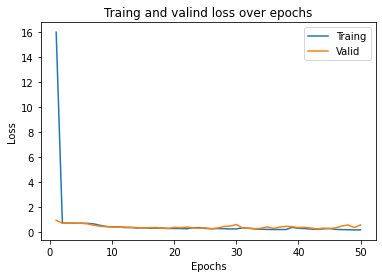

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Lowest loss happens in epoch 43
Total Time Spent: 22m 14s
Test Loss: 0.246 | Test Acc: 90.64%


In [33]:
# LR = 1e-2
import matplotlib.pyplot as plt
  
plt.plot(range(1, EPOCHS+1), Train_loss, label = "Traing")
plt.plot(range(1, EPOCHS+1), Val_loss, label = "Valid")
plt.title('Traing and valind loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Evaluation
model.load_state_dict(torch.load('vgg16-5layers-1st-1e-2.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print("Lowest loss happens in epoch " + str(best_epoch + 1))
print(f'Total Time Spent: {epoch_mins}m {epoch_secs}s')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

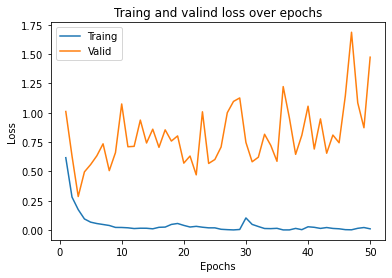

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Lowest loss happens in epoch 3
Total Time Spent: 1m 34s
Test Loss: 0.246 | Test Acc: 90.13%


In [49]:
# LR = 1e-3
import matplotlib.pyplot as plt
  
plt.plot(range(1, EPOCHS+1), Train_loss, label = "Traing")
plt.plot(range(1, EPOCHS+1), Val_loss, label = "Valid")
plt.title('Traing and valind loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Evaluation
model.load_state_dict(torch.load('vgg16-5layers-1st-1e-3.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print("Lowest loss happens in epoch " + str(best_epoch + 1))
print(f'Total Time Spent: {epoch_mins}m {epoch_secs}s')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

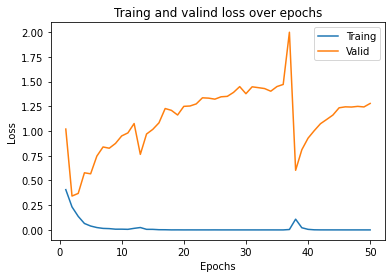

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Lowest loss happens in epoch 2
Total Time Spent: 1m 2s
Test Loss: 0.295 | Test Acc: 88.01%


In [63]:
# LR = 1e-4
import matplotlib.pyplot as plt
  
plt.plot(range(1, EPOCHS+1), Train_loss, label = "Traing")
plt.plot(range(1, EPOCHS+1), Val_loss, label = "Valid")
plt.title('Traing and valind loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Evaluation
model.load_state_dict(torch.load('vgg16-5layers-1st-1e-4.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print("Lowest loss happens in epoch " + str(best_epoch + 1))
print(f'Total Time Spent: {epoch_mins}m {epoch_secs}s')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')